In [50]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt, yaml
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
# import albumentations as A # Library for augmentations
# from albumentations.pytorch import ToTensorV2
import pandas as pd
from PIL import Image
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as Func
from datetime import datetime
from torchvision.io import read_image


In [51]:
def load_class_info(yaml_file):
    with open(yaml_file, 'r') as file:
            class_info = yaml.safe_load(file)
    return class_info['classes']
    
def label_transform(classes, labels, num_classes): #One-hot encoding
    class_to_index = {class_name: index for index, class_name in enumerate(classes)}
    target = np.zeros(num_classes, dtype=int)
    for label in labels:
        if label in class_to_index:
            index = class_to_index[label]
            target[index] = 1
    return target
    
def transform(image, keypoints, one_hot_label, num_classes, image_size=(224, 224), fusion='concat'):
    transform_ops = transforms.Compose([
        transforms.Resize(image_size),
    ])
    image = transform_ops(image)
    keypoints = torch.tensor(keypoints).float()
    one_hot_label = torch.tensor(one_hot_label).float()
    one_hot_channel = one_hot_label.unsqueeze(1).unsqueeze(2).expand(len(one_hot_label), image_size[0], image_size[1])
    one_hot_channel = one_hot_channel.sum(dim=0, keepdim=True)
    
    # input_combined = []

    if fusion == 'concat':
        input_combined = torch.cat((image, one_hot_channel), dim=0)
        # print("concat")

    elif fusion == 'add':
        if image.shape[0] == 3:
            padding = torch.zeros_like(image[0]).unsqueeze(0)
            padded_one_hot_channel = torch.cat([one_hot_channel, padding, padding], dim=0)
        input_combined = image + padded_one_hot_channel

    elif fusion == 'multiply':
        if image.shape[0] == 3:
            one_hot_channel = one_hot_channel.repeat(3, 1, 1)
        input_combined = image * one_hot_channel
        
    if fusion == 'concat':
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.0], std=[0.229, 0.224, 0.225, 1.0])
    else:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    input_combined = normalize(input_combined)
    
    return input_combined, keypoints

def denormalize_image(image):
    denormalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    image = denormalize(image)
    image = torch.clamp(image, 0, 1)
    return image

def visualize_keypoints(image, keypoints):
    image = denormalize_image(image)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=10, marker='.', c='r')
    plt.show()

In [52]:
class ClassDataset(Dataset):
    def __init__(self, dataset_folder, class_info_file, transform=None, label_transform=None, fusion_type='concat'):
        self.dataset_folder = dataset_folder
        self.transform = transform
        self.label_transform = label_transform
        self.imgs_files = self.load_data(dataset_folder)
        self.class_names = load_class_info(class_info_file)
        self.num_classes = len(self.class_names)
        self.fusion_type = fusion_type

    def load_data(self, dataset_folder):
        images_path = os.path.join(self.dataset_folder,"images/")
        annotations_path = os.path.join(self.dataset_folder,"annotations/")
        j_data = []
        for file in os.listdir(images_path):
            if file.endswith(".jpg"):
                json_path = os.path.join(annotations_path, file.split('.')[0] + '.json')
                with open(json_path) as f:
                    json_load = json.load(f)
                    for item in json_load['shapes']:
                        points = [value for row in item['points'] for value in row]
                        j_data.append({'image':  os.path.join(images_path,file),
                                     'label': item['label'],
                                     'points':points })
        json_data = pd.DataFrame(j_data)
        return json_data

    def get_keypoint(self, bboxes):
        centers = []
        for bbox in bboxes:
            center_x = (bbox[0] + bbox[2]) / 2
            center_y = (bbox[1] + bbox[3]) / 2
            centers.append((center_x, center_y))
        return centers
    
    def __len__(self):
        return len(self.imgs_files)

    def __getitem__(self, idx):
        target = {}
        img_path, label, bboxes_original = self.imgs_files.iloc[idx]
        label = [label]
        bboxes_original = [bboxes_original]
        keypoint_original = self.get_keypoint(bboxes_original)
        img_original = read_image(img_path).float() / 255.0

        if self.transform:
            label_transform = self.label_transform(self.class_names,label, self.num_classes)
            img, target['keypoints'] = self.transform(img_original, keypoint_original, label_transform, self.num_classes, fusion=self.fusion_type)
            target['labels'] = torch.as_tensor(label_transform, dtype=torch.int64)
        else:
            # img, bboxes = img_original, bboxes_original
            img, target['keypoints'] = img_original, keypoint_original
            target['labels'] = label

        return img, target, img_original
    

In [28]:
def collate_fn(batch):
    return tuple(zip(*batch))

# class_config_path = '../config/class.yaml'
class_config_path = '../../config/formated_class.yaml'
# DATASET_FOLDER_TRAIN = '../../dataset/robocup_all_test/'
DATASET_FOLDER_TRAIN = './../../../../RnD_datasets/robocup_dataset'
# DATASET_FOLDER_TRAIN = '../../dataset/robocup_test_dataset/'
train_path = os.path.join(DATASET_FOLDER_TRAIN,"train/")
val_path = os.path.join(DATASET_FOLDER_TRAIN,"val/")

fusion_type = 'concat'
# fusion_type = 'add'
# fusion_type = 'multiply'

train_dataset = ClassDataset(train_path, class_config_path, transform=transform, label_transform=label_transform, fusion_type=fusion_type)
valid_dataset = ClassDataset(val_path, class_config_path, transform=transform, label_transform=label_transform, fusion_type=fusion_type)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

concatenated input size =  torch.Size([4, 224, 224])
keypoint = tensor([[472.5000, 393.5000]])
label = tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])


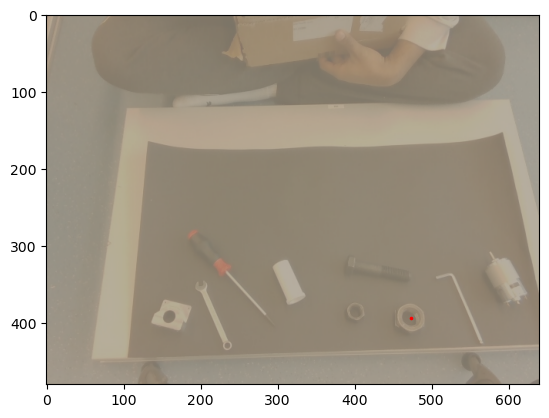

In [29]:
iterator = iter(valid_loader)
images, targets, img = next(iterator)
image_number = 0
num_channels = images[image_number].shape[0]

print("concatenated input size = ", images[image_number].shape)
print(f"keypoint = {targets[image_number]['keypoints']}\nlabel = {targets[image_number]['labels']}")

visualize_keypoints(img[image_number], targets[image_number]['keypoints'])

In [30]:
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=20, num_keypoints=1, num_channels=4): 
        super(CustomResNet18, self).__init__()
        
        self.num_keypoints = num_keypoints
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc_cls = nn.Linear(self.resnet18.fc.in_features, num_classes)
        self.fc_kpts = nn.Linear(self.resnet18.fc.in_features, self.num_keypoints * 2)
        self.resnet18.fc = nn.Identity()
        
    def forward(self, x):
        features = self.resnet18(x)
        class_outputs = self.fc_cls(features)
        keypoint_outputs = self.fc_kpts(features)
        return class_outputs, keypoint_outputs.reshape(-1, self.num_keypoints, 2)

In [31]:
def train_model(model, criterion_cls, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=25):
    train_losses = []
    valid_losses = []
    key_train_losses = []
    key_valid_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_kpt_loss = 0.0

        for images, targets, labels in train_loader:
            labels = [target['labels'].to(device) for target in targets]
            images = torch.stack(images).to(device)
            ground_truth_keypoints = torch.stack([target['keypoints'].to(device) for target in targets])

            labels_tensor = torch.stack(labels)
            class_indices = torch.argmax(labels_tensor, dim=1)

            optimizer.zero_grad()

            class_outputs, keypoint_outputs = model(images)
            
            loss_cls = criterion_cls(class_outputs, class_indices)
            loss_kpt = criterion_kpt(keypoint_outputs, ground_truth_keypoints)
            # loss_kpt = LaplaceNLLLoss(keypoint_outputs, ground_truth_keypoints, 0.01)
            class_loss = loss_cls 
            kpt_loss = loss_kpt
            # total_loss = loss_cls + loss_kpt # Combine losses for backpropagation
            class_loss.backward(retain_graph=True)
            kpt_loss.backward()
            # kpt_loss.backward()
            optimizer.step()
            total_train_loss += loss_cls.item()
            total_kpt_loss += loss_kpt.item()

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_kpt_loss = total_kpt_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Train Keypoint Loss: {avg_kpt_loss}')

        model.eval()
        total_val_loss = 0.0
        total_val_kpt_loss = 0.0

        with torch.no_grad():
            for images, targets, labels in valid_loader:
                labels = [target['labels'].to(device) for target in targets]
                images = torch.stack(images).to(device)
                ground_truth_keypoints = torch.stack([target['keypoints'].to(device) for target in targets])

                labels_tensor = torch.stack(labels)
                class_indices = torch.argmax(labels_tensor, dim=1)

                class_outputs, keypoint_outputs = model(images)
                
                loss_cls = criterion_cls(class_outputs, class_indices)
                loss_kpt = criterion_kpt(keypoint_outputs, ground_truth_keypoints)
                # loss_kpt = LaplaceNLLLoss(keypoint_outputs, ground_truth_keypoints, 0.01)
                
                total_val_loss += loss_cls.item() 
                total_val_kpt_loss += loss_kpt.item()

        avg_val_loss = total_val_loss / len(valid_loader.dataset)
        avg_val_kpt_loss = total_val_kpt_loss / len(valid_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss}, Val Keypoint Loss: {avg_val_kpt_loss}')
        
        train_losses.append(avg_train_loss)
        valid_losses.append(avg_val_loss)
        key_train_losses.append(avg_kpt_loss)
        key_valid_losses.append(avg_val_kpt_loss)

    return model, train_losses, key_train_losses, valid_losses, key_valid_losses  # Optionally return the model

In [32]:
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
iterator = iter(valid_loader)
combined_input, targets, img = next(iterator)
image_number = 0

num_channels = combined_input[image_number].shape[0]
num_classes = len(load_class_info(class_config_path))
model = CustomResNet18(num_classes=num_classes, num_keypoints=1, num_channels=num_channels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion_cls = nn.CrossEntropyLoss()
criterion_kpt = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
epochs_train = 100
trained_model, train_loss, key_train_loss, val_loss, key_val_loss = train_model(model, criterion_cls, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=epochs_train)
# train_model(model, criterion, optimizer, num_epochs)
torch.save(model.state_dict(), './models/complete_dataset/resnet18_conditional_'+fusion_type+'_kpt_cls_loss_1.pth')

Epoch 1/100, Training Loss: 0.08830573518877735, Train Keypoint Loss: 2674.9408607256214
Epoch 1/100, Validation Loss: 0.10331308674167942, Val Keypoint Loss: 2141.5272423986485
Epoch 2/100, Training Loss: 0.08957488590932935, Train Keypoint Loss: 1151.6015936275999
Epoch 2/100, Validation Loss: 0.11941073314563648, Val Keypoint Loss: 677.6527554898648
Epoch 3/100, Training Loss: 0.09076022386937319, Train Keypoint Loss: 475.6870444291093
Epoch 3/100, Validation Loss: 0.10379568899000013, Val Keypoint Loss: 468.110269214527
Epoch 4/100, Training Loss: 0.08950633998821389, Train Keypoint Loss: 394.03796366934256
Epoch 4/100, Validation Loss: 0.11318396774498192, Val Keypoint Loss: 475.17697846283784
Epoch 5/100, Training Loss: 0.09010146509177745, Train Keypoint Loss: 385.337314764401
Epoch 5/100, Validation Loss: 0.09084149927706332, Val Keypoint Loss: 469.4273490287162
Epoch 6/100, Training Loss: 0.08922022300948973, Train Keypoint Loss: 379.42388985261346
Epoch 6/100, Validation Loss

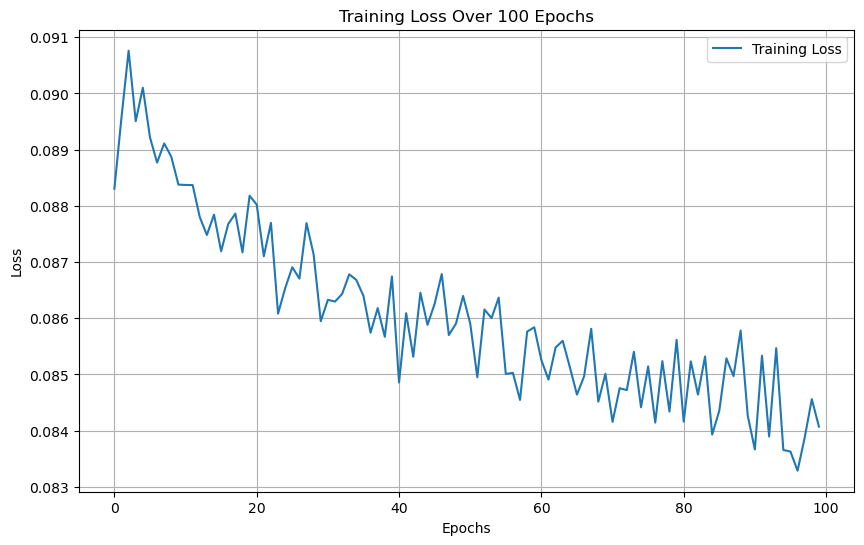

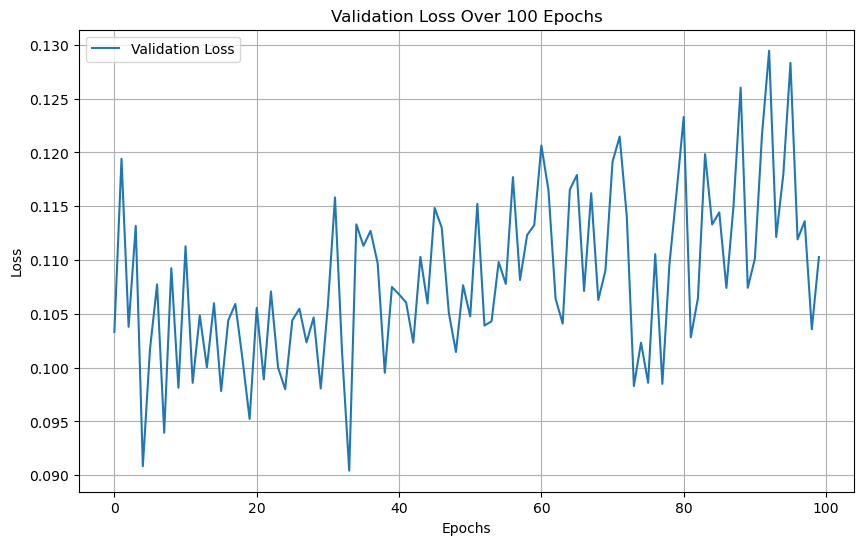

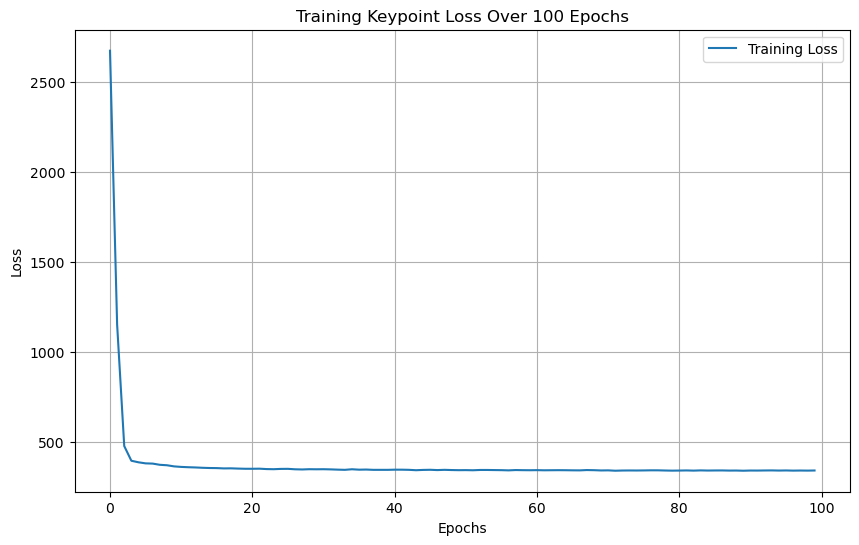

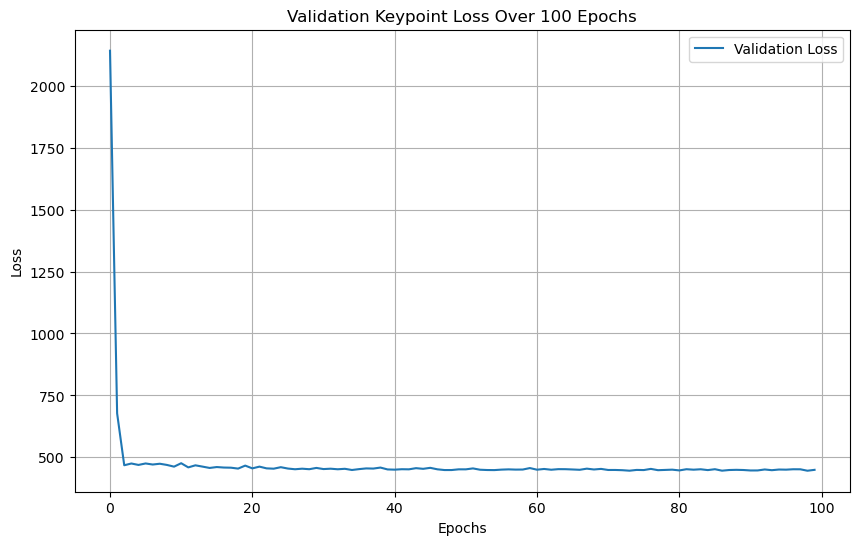

In [34]:
def plot_train_losses(train_losses, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss Over 100 Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

def plot_val_losses(valid_losses, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Validation Loss Over 100 Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

def plot_train_kpt_losses(train_kpt_losses, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(train_kpt_losses, label='Training Loss')
    plt.title('Training Keypoint Loss Over 100 Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

def plot_val_kpt_losses(val_kpt_losses, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(val_kpt_losses, label='Validation Loss')
    plt.title('Validation Keypoint Loss Over 100 Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

# path_train_loss = "./plots/complete_dataset/train_losses_resnet18_conditional_"+fusion_type+"_1.png"
# path_val_loss = "./plots/complete_dataset/val_losses_resnet18_conditional_add_"+fusion_type+"_1.png"
# path_train_kpt = "./plots/complete_dataset/train_kpt_losses_resnet18_conditional_"+fusion_type+"_1.png"
# path_val_kpt = "./plots/complete_dataset/val_kpt_losses_resnet18_conditional_"+fusion_type+"_1.png"

# path_train_loss = "./plots/complete_dataset/train_losses_resnet18_conditional_"+fusion_type+"_kpt_loss_1.png"
# path_val_loss = "./plots/complete_dataset/val_losses_resnet18_conditional_add_"+fusion_type+"_kpt_loss_1.png"
# path_train_kpt = "./plots/complete_dataset/train_kpt_losses_resnet18_conditional_"+fusion_type+"_kpt_loss_1.png"
# path_val_kpt = "./plots/complete_dataset/val_kpt_losses_resnet18_conditional_"+fusion_type+"_kpt_loss_1.png"

path_train_loss = "./plots/complete_dataset/train_losses_resnet18_conditional_"+fusion_type+"_kpt_cls_loss_1.png"
path_val_loss = "./plots/complete_dataset/val_losses_resnet18_conditional_"+fusion_type+"_kpt_cls_loss_1.png"
path_train_kpt = "./plots/complete_dataset/train_kpt_losses_resnet18_conditional_"+fusion_type+"_kpt_cls_loss_1.png"
path_val_kpt = "./plots/complete_dataset/val_kpt_losses_resnet18_conditional_"+fusion_type+"_kpt_cls_loss_1.png"

plot_train_losses(train_loss, save_path=path_train_loss)
plot_val_losses(val_loss, save_path=path_val_loss)
plot_train_kpt_losses(key_train_loss, save_path=path_train_kpt)
plot_val_kpt_losses(key_val_loss, save_path=path_val_kpt)

In [45]:
# trained_model = CustomResNet50()
# model.load_state_dict(torch.load('./models/resnet50_conditional_concat_2.pth'))
# model.load_state_dict(torch.load('./models/resnet50_conditional_add_1.pth'))
# model.load_state_dict(torch.load('./models/resnet50_conditional_mul_1.pth'))
model.load_state_dict(torch.load('./models/complete_dataset/resnet18_conditional_'+fusion_type+'_kpt_cls_loss_1.pth'))
model.eval()  # Switch to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("successful")

successful


In [46]:
image = Image.open('./test/test1.jpg')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
image_tensor = transform(image)
print(image_tensor.shape)

torch.Size([3, 224, 224])


In [47]:
class_file = load_class_info(class_config_path)

label = ['S40_40_G']
label_encoded = label_transform(class_file, label, len(class_file))

one_hot_label = torch.tensor(label_encoded).float()
one_hot_channel = (one_hot_label != 0).nonzero(as_tuple=True)[0].item()
one_hot_channel = one_hot_label[one_hot_channel]
tens = torch.full((1, 224, 224), one_hot_channel)
# input_combined = torch.cat((image_tensor, tens), dim=0)


if fusion_type == 'concat':
        input_combined = torch.cat((image_tensor, tens), dim=0)

elif fusion_type == 'add':
    if image_tensor.shape[0] == 3:
        padding = torch.zeros_like(image_tensor[0]).unsqueeze(0)
        padded_one_hot_channel = torch.cat([tens, padding, padding], dim=0)
    input_combined = image_tensor + padded_one_hot_channel

elif fusion_type == 'multiply':
    if image_tensor.shape[0] == 3:
        one_hot_channel = tens.repeat(3, 1, 1)
    input_combined = image_tensor * tens


input_combined = input_combined.unsqueeze(0)
input_combined = input_combined.to(device)
print(input_combined.shape)
# label_encoded = tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
# label_channel = torch.full((1, 1, 224, 224), label_encoded, dtype=torch.float32)

torch.Size([1, 4, 224, 224])


In [49]:
import time

start_time = time.time()
with torch.no_grad():
    outputs = model(input_combined)
end_time = time.time()
inference_time = (end_time - start_time) * 1000
print(f'Inference time: {inference_time:.2f} ms')

Inference time: 4.86 ms


In [59]:
def automated_train_script(class_config_path, DATASET_FOLDER_TRAIN, train_path, val_path, epochs_train, fusion_types):
    
    for fusion, epochs in zip(fusion_types, epochs_train):
        print('***************************'+fusion+'___________'+epochs+'*********************************')
        
        train_dataset = ClassDataset(train_path, class_config_path, transform=transform, label_transform=label_transform, fusion_type=fusion)
        valid_dataset = ClassDataset(val_path, class_config_path, transform=transform, label_transform=label_transform, fusion_type=fusion)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
        valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

        iterator = iter(valid_loader)
        combined_input, targets, img = next(iterator)
        image_number = 0
        print("concatenated input size = ", combined_input[image_number].shape)
        
        num_channels = combined_input[image_number].shape[0]
        num_classes = len(load_class_info(class_config_path))

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        model = CustomResNet18(num_classes=num_classes, num_keypoints=1, num_channels=num_channels)
        model.to(device)
        
        criterion_cls = nn.CrossEntropyLoss()
        criterion_kpt = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        trained_model, train_loss, key_train_loss, val_loss, key_val_loss = train_model(model, criterion_cls, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=epochs)

        torch.save(model.state_dict(), './models/updated_models/resnet18_conditional_'+fusion+'_'+epochs+'_epochs.pth')

        losses = [train_loss, val_loss, key_train_loss, key_val_loss]
        label_losses = ['Training Loss', 'Validation Loss', 'Keypoint Training Loss', 'Keypoint Validation Loss']
        plot_paths = ['train_losses', 'val_losses', 'kpt_train_losses', 'kpt_val_losses']
        
        for loss, label_loss, plot_path in zip(losses, label_losses, plot_paths):
            path = "./plots/updated_models/"+plot_path+"_resnet18_conditional_"+fusion+"_"+epochs+"_epochs.png"
            plots_all(loss, epochs_train, label_loss, path)

        print('$$$$$$$$$$$$$$$$$$$$$$_%%%%%%%%%%%%%%%%%%%%%%%_&&&&&&&&&&&&&&&&&&&&&&&&&&&&&_#############################')

In [58]:
def plots_all(loss, epochs, label_loss, path):
    plt.figure(figsize=(10, 6))
    plt.plot(loss, label=label_loss)
    plt.title(label_loss+' Over'+epochs+' Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(path)
    plt.show()

In [ ]:
class_config_path = '../../config/formated_class.yaml'
DATASET_FOLDER_TRAIN = './../../../../RnD_datasets/robocup_dataset'
train_path = os.path.join(DATASET_FOLDER_TRAIN,"train/")
val_path = os.path.join(DATASET_FOLDER_TRAIN,"val/")
epochs_list = [100, 250, 500, 1000]
fusion_types = ['concat','add','multiply']

automated_train_script(class_config_path, DATASET_FOLDER_TRAIN, train_path, val_path, epochs_list, fusion_types)


